In [ ]:
import pandas
import PIL
import os
import numpy as np
from tensorflow.keras.applications import MobileNetV3Large, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from IPython.display import display, Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile, os, shutil
import tensorflow as tf

In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
100% 1.02G/1.03G [00:36<00:00, 33.2MB/s]
100% 1.03G/1.03G [00:36<00:00, 30.2MB/s]


In [ ]:
!pip install split-folders
import splitfolders

In [ ]:
!unzip '/content/asl-alphabet.zip'

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

In [ ]:
import os
import shutil

# Path ke dataset
dirData = '/content/asl_alphabet_train'
dataType = 'asl_alphabet_train'
delClass = ['del', 'nothing', 'space']

# Path ke dataset train
temp = os.path.join(dirData, dataType)
for folder in delClass:
    temp2 = os.path.join(temp, folder)
    try:
        shutil.rmtree(temp2)
        print(f"Successfully removed {temp2}")
    except Exception as e:
        print(f"Failed to remove {temp2}: {e}")


Successfully removed /content/asl_alphabet_train/asl_alphabet_train/del
Successfully removed /content/asl_alphabet_train/asl_alphabet_train/nothing
Successfully removed /content/asl_alphabet_train/asl_alphabet_train/space


In [ ]:
# rename folder 'Train' into 'input'
try:
  os.rename(os.path.join(dirData, dataType[1]),
            os.path.join(dirData, 'input'))
except OSError:
    pass

In [ ]:
import os

# Path asli ke dataset
dirData = '/content/asl_alphabet_train'
dataType = 'asl_alphabet_train'

# Nama baru untuk folder
newFolderName = 'input'

# Rename folder 'asl_alphabet_train' menjadi 'input'
try:
    os.rename(os.path.join(dirData, dataType), os.path.join(dirData, newFolderName))
    print(f"Successfully renamed {dataType} to {newFolderName}")
except OSError as e:
    print(f"Failed to rename {dataType}: {e}")

Successfully renamed asl_alphabet_train to input


In [ ]:
# split data training into two folders, named 'train' and 'val'
try:
   splitfolders.ratio(os.path.join(dirData, 'input'),
                       output = os.path.join(dirData, 'output'),
                      ratio = (0.70, 0.30))
except:
    pass

Copying files: 78000 files [00:16, 4736.06 files/s]


In [ ]:
# delete the folder named 'input'
try:
    shutil.rmtree(os.path.join(dirData, 'input'))
except:
    pass

In [ ]:
dirTrain = os.path.join('/content/asl_alphabet_train/output/train')
dirVal = os.path.join('/content/asl_alphabet_train/output/val')

In [ ]:
if os.listdir(dirTrain) == os.listdir(dirVal):
    labels = os.listdir(dirTrain)
labels

['U',
 'D',
 'X',
 'L',
 'O',
 'B',
 'P',
 'H',
 'C',
 'T',
 'I',
 'J',
 'E',
 'Z',
 'S',
 'Q',
 'M',
 'K',
 'A',
 'Y',
 'F',
 'W',
 'N',
 'V',
 'R',
 'G']

In [ ]:
# Membuat ImageDataGenerator untuk augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range = 0.2,
    width_shift_range = 0.4,
    height_shift_range = 0.4
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Membuat generator untuk dataset
train_generator = train_datagen.flow_from_directory(
    dirTrain,
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse'
)

validation_generator = validation_datagen.flow_from_directory(
    dirVal,
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse'
)

Found 54600 images belonging to 26 classes.
Found 23400 images belonging to 26 classes.


In [ ]:
# Load the VGG16 model with pre-trained ImageNet weights, excluding the top fully connected layers
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Create a new Sequential model and add the VGG16 base
model = Sequential()
model.add(conv_base)

# Add flatten layer to flatten the 3D output to 1D
model.add(Flatten())

# Add the dense layers as per VGG16 architecture
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))

# Add the final dense layer for classification
model.add(Dense(26, activation='softmax'))  # Assuming 26 classes as in your original code

# Freeze the layers of the VGG16 base model
conv_base.trainable = False

# Summary of the model
model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 4096)              33558528  
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 26)                106522    
                                                                 
Total params: 65161050 (248.57 MB)
Trainable params: 50446362 (192.44 MB)
Non-trainable params: 14714688 (56.13 MB)
_______

In [ ]:
# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [ ]:
# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
1706/1706 [==============================] - 508s 294ms/step - loss: 1.2668 - accuracy: 0.6099 - val_loss: 0.2855 - val_accuracy: 0.8982
Epoch 2/10
1706/1706 [==============================] - 494s 290ms/step - loss: 0.7256 - accuracy: 0.7602 - val_loss: 0.1815 - val_accuracy: 0.9355
Epoch 3/10
1706/1706 [==============================] - 499s 292ms/step - loss: 0.5926 - accuracy: 0.8055 - val_loss: 0.1169 - val_accuracy: 0.9602
Epoch 4/10
1706/1706 [==============================] - 469s 275ms/step - loss: 0.5320 - accuracy: 0.8225 - val_loss: 0.1154 - val_accuracy: 0.9618
Epoch 5/10
1706/1706 [==============================] - 459s 269ms/step - loss: 0.4708 - accuracy: 0.8423 - val_loss: 0.1280 - val_accuracy: 0.9551
Epoch 6/10
1706/1706 [==============================] - 497s 291ms/step - loss: 0.4362 - accuracy: 0.8539 - val_loss: 0.0862 - val_accuracy: 0.9698
Epoch 7/10
1504/1706 [=========================>....] - ETA: 49s - loss: 0.4061 - accuracy: 0.8620

In [ ]:
model.save('VGG16NewModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('MobilenetNewDataset.h5')

1/1 [==============================] - 0s 448ms/step
Prediksi Kelas: A, digit: 0, score: 1.0


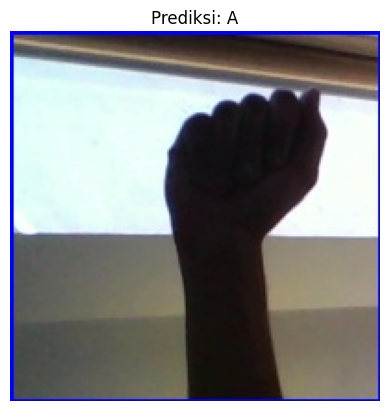

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

# Fungsi untuk memuat dan memproses gambar
def load_and_process_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255  # Normalisasi gambar
    return img_array

# Load model yang telah disimpan
model = load_model('MobileNetNewModel.h5')

# Path ke gambar uji
test_image_path = '/content/asl_alphabet_test/asl_alphabet_test/A_test.jpg'

# Memuat dan memproses gambar uji
img_array = load_and_process_image(test_image_path)

# Melakukan prediksi
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Menampilkan hasil prediksi
labels = {i: chr(65 + i) for i in range(26)}
predicted_label = labels[predicted_class]
confidence_score = predictions[0][predicted_class]
print(f"Prediksi Kelas: {predicted_label}, digit: {predicted_class}, score: {confidence_score}")

# Menampilkan gambar uji
img = image.load_img(test_image_path)
plt.imshow(img)
plt.title(f"Prediksi: {predicted_label}")
plt.axis('off')
plt.show()